1 Banque de données sur les réseaux sociaux

On s’intéresse dans ce premier exemple à un ensemble de données contenant des profils
d’utilisateurs d’un réseau social, qui, en interagissant avec une publicité sur un produit, ont
acheté ce produit ou non.

Le « dataset » étudié, enregistré au format csv, comporte les informations suivantes des
utilisateurs :

• identifiant ;
• sexe ("F" ou "M") ;
• âge ;
• salaire annuel ;
• indication d’achat du produit (0 pour non ou 1 pour oui).

Dans une première étude nous souhaitons prédire le comportement des utilisateurs de ce
réseau social pour l’achat du produit (une voiture ici), en fonction de leur salaire annuel et de
leur âge.
On doit dont extraire du « dataset »une matrice des observations (ou entrées) de taille (N, 2),
notée Xt et un vecteur de N étiquettes (sorties) yt.
1.1 Préparation des données


In [103]:
#pip install -U scikit-learn pandas matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dataset = pd.read_csv("Reseaux_sociaux_auto.csv")
#print(dataset)

Pour extraire ces données sous forme se tableaux numpy, nous avons utiliser la méthode.to_numpy. Ainsi, pour créer une matrice de taille (N,d) où N et d sont respectivement le nombre d’échantillons et le nombre de variables à étudier :

Xt = dataset[["NomVariable1", "NomVariable2"]].to_numpy(dtype=float) créera une
matrice de taille (N,d).
Une particularité remarquable est que les chaînes de caractères écrites avec des nombres sont
automatiquement converties en entiers ou flottants. Comme ici nous aurons besoin de flottants,
on le précise avec dtype=float.

Dans notre cas, la colonne "Sexe" sera convertie, pour chaque ligne avec la chaine de
caractères "F" ou "M". Il est possible de faire une boucle avec test pour substituer un "F" par
0 et un "M" par 1 (généralisation possible si ce n’est pas binaire). Sinon, une alternative est
d’utiliser les deux lignes de codes suivantes :

In [104]:
""""yt = pd.Categorical( dataset ["Sexe"]).astype( 'category' )
y = yt.reshape(( yt.shape[0], 1)) #Pour mettre au format matrice de taille (400,1)
print(y)"""

'"yt = pd.Categorical( dataset ["Sexe"]).astype( \'category\' )\ny = yt.reshape(( yt.shape[0], 1)) #Pour mettre au format matrice de taille (400,1)\nprint(y)'

Dans une première étude nous souhaitons prédire le comportement des utilisateurs de ce réseau social pour l’achat du produit (une voiture ici), en fonction de leur salaire annuel et de leur âge.

On doit dont extraire du « dataset »une matrice des observations (ou entrées) de taille (N, 2), notée Xt et un vecteur de N étiquettes (sorties) yt.

In [105]:
#extrait du fichier Reseaux_sociaux_auto.csv une matrice numpy Xt de données d’entrées avec les deux variables
#"Salaire" et "Age".
"""Xt_3 = dataset[["Age", "Salaire","Sexe"]].to_numpy()
for i in range (np.shape(Xt)[0]):
    if Xt_3[i,2]=="M":
        Xt_3[i,2]=1
    else:
        Xt_3[i,2]=0
#print(Xt_3)"""
Xt = dataset[["Age", "Salaire"]].to_numpy(dtype=float)
#De même avec le vecteur de sortie yt, issu de la donnée "Achat"
yt = dataset[["Achat"]].to_numpy(dtype=int)
#print(yt)

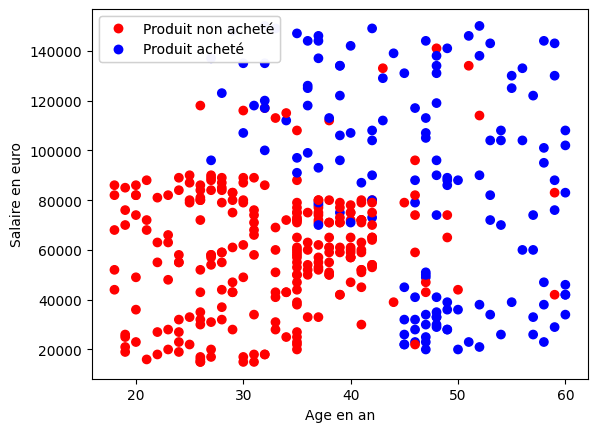

In [106]:
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots()
scatter = ax.scatter(Xt[:, 0], Xt[:, 1], c=yt, cmap=ListedColormap(['r', 'b']))
handles, _ = scatter.legend_elements()
labels = ["Produit non acheté", "Produit acheté"]
legend1 = ax.legend(handles, labels, loc="best")
ax.add_artist(legend1)
ax.set_xlabel("Age en an")
ax.set_ylabel("Salaire en euro")
plt.show()

Avant de mettre en oeuvre l’algorithme de régression logistique, il s’avére nécessaire
de normaliser les différentes données afin de ne pas rendre une donnée prédominante dans le
modèle. Cela est particulièrement le cas dans les problèmes de classification... Ainsi, les données
d’entrées seront standardisées selon une loi centrée réduite de la forme (V − μ)/σ avec V une valeur brute,
μ et σ respectivement l’espérance et l’écart-type de l’ensemble des valeurs V .
Les caractéristiques d’une variable centrée-réduite sont une espérance nulle ainsi qu’un écart
type de 1. On trouve donc des données indépendantes de l’unité ou de l’échelle choisie et des
variables ayant la même moyenne et la même dispersion.

In [ ]:
def centrée_réduite(Xt): 
    D=np.shape(Xt)[1]
    mu=np.zeros(D)
    sigma=np.zeros(D)
    mu[0]=np.mean(Xt[:,0])
    mu[1]=np.mean(Xt[:,1])
    sigma[0]=np.std(Xt[:,0])
    sigma[1]=np.std(Xt[:,1])
    #print(mu)
    #print(sigma)
    n=len(Xt)
    Xtn=np.zeros((n,2))
    for i in range(n):
        Xtn[i]=(Xt[i]-mu)/sigma
    return Xtn
Xtn=centrée_réduite(Xt)
#print(Xtn)
#print("Ecart type salaires centrés réduits=",Xtn[:,0].std())
#print("Ecart type age centrés réduits=",Xtn[:,1].std())

[[-1.13662058]
 [ 2.44067677]
 [ 1.2206842 ]]


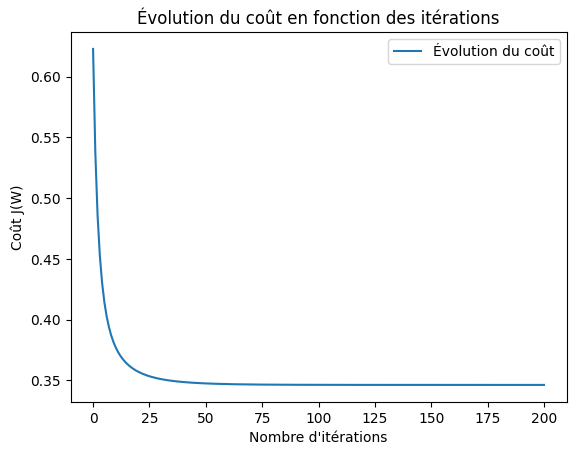

In [ ]:
"""fonction modèle h prenant en arguments la matrice des observations (entrées ou « fea-
tures » ) X et le vecteur des paramètres (poids) W et qui retourne la valeur : σ(X.W ), où
σ est la fonction Sigmoïdale définie par :σ(z) = 1/(1+exp(-z))"""
def sigmoide(z):
    return 1 / (1 + np.exp(-z))  # valeurs comprises entre 0 et 1

def h_function(X, W):
    return sigmoide(np.dot(X, W))
"""En régression logistique, on veut apprendre un modèle qui prédit correctement si une observation appartient à la *
classe y=1 ou y=0 / Le modèle prédit une probabilité : y' =σ(XW)
objectif : Trouver les meilleurs paramètres W pour que y' soit proche de y=> on a besoin d'une fonction coût J(W)
comment?: P(yi=1|Xi,W)=σ(XiW) et P(yi=0|Xi,W)=1−σ(Xi,W) donc plus compact: P(y_i|X_i W) = σ(X_iW)^y_i*(1-σ(X_i,W))^(1-y_i)
Vraisemblance pour tous les exemples:(les observations sont indépendantes:  
L(W) = ∏(i=1àN)P(y_i|X_i,W)=∏(i=1àN)σ(X_iW)^y_i*(1-σ(X_iW))^(1-y_i))
donc :logL(W)=∑(i=1 à N)[y_ilog(σ(X_i W))+(1-y_i)log(1-σ(X_iW))]
Pour faciliter l'optimisation, on prend le logarithme et on le transforme en fonction coût négative: J(W)=-log(L(W))/N"""
def J(X, y, W):
    N = X.shape[0]
    h = h_function(X, W)
    J = (-1 / N) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return J
"""démo de la formule de gradiant: gradJ(W))=(1/N)*X.T*(σ(XW)-y)
on a : J(W) =-(1/N)*∑[y_i log(h_i)+(1-y_i)log(1-h_i)] on pose h_i=h(X_iW)
donc: ∂J/∂W =-(1/N)*∑[(y_i/h_i)*∂h_i/∂W+((1-y_i)/(1-h_i))*∂(1-h_i)/∂W] et on sait que: ∂σ/∂W=σ(XW)*(1-σ(XW))*X
donc: ∂J/∂W = (1/N)*∑X_i*(σ(X_iW)-y_i) donc matriciellement: ∇J(W) =(1/N)* X.T*(σ(XW)-y)
"""
def gradient(X, y, W):
    N = X.shape[0]
    h = h_function(X, W)
    grad = (1 / N) * np.dot(X.T, (h - y))  # Produit matriciel
    return grad # S'assurer que grad a la même forme que W

"""def gradient(X, y, W):
    N = X.shape[0]
    h = h_function(X, W)
    grad = grad = (1 / N) * np.dot(X.T, (h - y)) 
    return grad"""

def Regression_Logistique(Xt, Yt,nbre_iter,alpha):
    N, D = Xt.shape  
    Xt = np.hstack((np.ones((N, 1)), Xt))  # Ajout de la colonne de biais w0
    W = np.ones((D + 1, 1))*0.5  # Initialisation des poids à zéro
    L_W=[W]
    Histoire_cout = [J(Xt, Yt, W)]  # Liste pour stocker l'évolution du coût
    for k in range(nbre_iter):
        W = W - alpha * gradient(Xt, Yt, W)  # Mise à jour des poids
        L_W.append(W)
        Histoire_cout.append(J(Xt, Yt, W))  # Stockage du coût
    return L_W, Histoire_cout  # Retourne les poids finaux et l'évolution du coût

"""def Regression_Logistique(X, y, nb_iter, alpha):
    N, D = X.shape
    X = np.hstack((np.ones((np.shape(X)[0], 1)), X))
    W=np.ones((D+1,))*0.5  # initialisaion arbitraire des poids à  0.5
    h = h_function(X, W)
    L_W = [W]
    hist_cout = [J(X, y, W)]
    for i in range(nb_iter):
        W = W - alpha * gradient(X, y, W)
        L_W.append(W)
        hist_cout.append(J(X, y, W))
    return L_W, hist_cout"""
L_W, hist_cout = Regression_Logistique(Xtn, yt, 200, 1)
print(L_W[-1])
plt.plot(range(len(hist_cout)), hist_cout, label="Évolution du coût")
plt.xlabel("Nombre d'itérations")
plt.ylabel("Coût J(W)")
plt.title("Évolution du coût en fonction des itérations")
plt.legend()
plt.show()

Nous allons maintenant analyser les résultats et visualiser graphiquement les résultats de
l’apprentissage automatique. Pour cela, une méthode consiste à effectuer un maillage du plan
avec une résolution de P points. Les axes du plan seront délimités grâce aux valeurs extrémales
des variables normalisées

In [109]:
resolution =100
# Calcul des bornes des axes
x0lim =(min(Xt[:,0])-0.5,max(Xt[:,0])+0.5)
x1lim =(min(Xt[:,1])-0.5,max(Xt[:,1])+0.5)
# Meshgrid
x0 = np. linspace (x0lim[0],x0lim[1],resolution)
x1 = np. linspace (x1lim[0],x1lim[1],resolution)
X0,X1 = np.meshgrid(x0, x1)
# Assemblage des 2 variables
XX = np.vstack((X0.ravel(),X1.ravel())).T
#XX = np.hstack((np.ones((XX.shape[0], 1)), XX))
# Prédictions du modèle de régression logistique
def prediction(X,W):
    N=X.shape[0]
    X=np.hstack((np.ones((N,1)),X))
    print(np.shape(X))
    probs = h_function(X, W)
    preds = (probs >= 0.5).astype(int)  # Convertir les probabilités en 0 ou 1
    return preds
W= L_W[-1]
print(W)
Z = prediction (XX, W) # prédiction pour chaque point du maillage

Z = Z.reshape((resolution,resolution))
y= prediction (Xtn,W) # prédiction pour les points du \og dataset \fg~
print(np.shape(Xtn))

[[-1.13662058]
 [ 2.44067677]
 [ 1.2206842 ]]
(10000, 3)
(400, 3)
(400, 2)


(10000, 3)


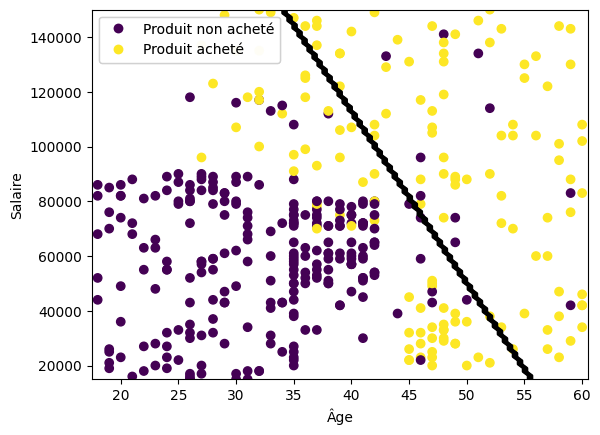

In [110]:
# Centrer et réduire les données du maillage
XX_centered_reduced = centrée_réduite(XX)

# Prédictions du modèle de régression logistique sur les données centrées-réduites
Z = prediction(XX_centered_reduced, W)  # prédiction pour chaque point du maillage
Z = Z.reshape((resolution, resolution))

# Tracer la frontière de décision
fig, ax = plt.subplots()
scatter = ax.scatter(Xt[:, 0], Xt[:, 1], c=yt)  # Scatter plot des points réels
handles, _ = scatter.legend_elements()
labels = ["Produit non acheté", "Produit acheté"]
legend1 = ax.legend(handles, labels, loc="best")
ax.add_artist(legend1)
plt.xlabel("Âge")
plt.ylabel("Salaire")

# Tracer la zone de séparation
ax.contour(X0, X1, Z, colors='k')  # Tracer la frontière de séparation
plt.show()

Pour évaluer la performance d’un algorithme de classification, on peut regarder la matrice
de confusion des prédictions. Dans notre cas de classification binaire, il s’agit d’une matrice qui
se présente de la façon: 

                |Classe prédite 0     |Classe prédite 1

Classe réelle 0 |VRAIS NÉGATIFS (VN)  |FAUX POSITIFS (FN)

Classe réelle 1 |FAUX NEGATIFS (FP)   |VRAIS POSITIFS (VP)

• Sensibilité = Rappel = Taux de vrais positifs = VP/(VP+VN)

• Spécificité = Taux de vrais négatifs = VN/(VN + FP)

• Précision = VP/(VP  +FP)

• Justesse = (VP + VN)/(VP + FP + VN + FN)

• Score-F = Moyenne harmonique (Précision, Sensibilité) = (2 × P reci sion × Sensibilite) / (Sensibilite + Precision)

In [111]:

# Calcul de la matrice de confusion
VP = np.sum((yt == 1) & (y == 1))
VN = np.sum((yt == 0) & (y == 0))
FP = np.sum((yt == 0) & (y == 1))
FN = np.sum((yt == 1) & (y == 0))

C = np.array([[VP, FN], [FP, VN]])
print("Matrice de confusion :")
print(C)
sensibilite = VP / (VP + FN)
precision = VP / (VP + FP)
justesse = (VP + VN) / (VP + VN + FP + FN)
score_f1 = 2 * (precision * sensibilite) / (precision + sensibilite)
probs = sigmoide(np.dot(np.hstack((np.ones((np.shape(XX)[0],1)),XX)), L_W[-1]))
for u in probs:
    if u==0:
        print(probs) 
print("Sensibilité :", sensibilite)
print("Précision :", precision)
print("Justesse :", justesse)
print("Score-F1 :", score_f1)

Matrice de confusion :
[[102  41]
 [ 21 236]]
Sensibilité : 0.7132867132867133
Précision : 0.8292682926829268
Justesse : 0.845
Score-F1 : 0.7669172932330828


Nous avons vu comment programmer "à la main" un algorithme de régression logistique
pour faire de la classification binaire. Cependant, pour des problèmes plus complexes, on peut

être amené à utiliser des bibliothèques qui utilisent les mêmes principes que ceux codés précé-
demment.

Le module scikit-learn va nous permettre d’entraîner notre modèle de régression logis-
tique. La régression logistique est implémentée dans la classe LogisticRegression du module linear_model de scikit-learn. Il existe une multitude de classes dans différents modules de

scikit-learn. Néanmoins, les méthodes associées sont souvent similaires. On retiendra la mé-
thode .fit() pour entrainer le modèle sur un jeu de données, ou encore la méthode .predict()

pour prédire des résultats avec le modèle une fois entraîné...
On instancie un objet de la classe de modèle qui nous intéresse, ici LogisticRegression.
Nous utilisons une régression logistique « classique », sans pénalisation/régularisation. Il nous
faut donc fixer l’argument penalty à none. Il ne reste plus qu’à entraîner cet objet sur les données
d’entraînement avec la méthode .fit.

c:\Users\Ahmed_El_Ayeb\Desktop\Ahmed_El_Ayeb\my_project\machine_learining\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


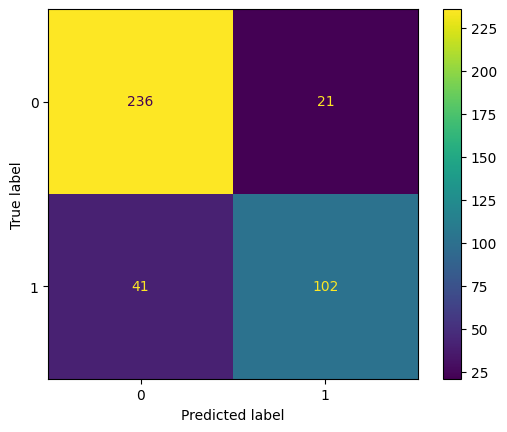

In [112]:
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Modele_RL = linear_model.LogisticRegression(penalty=None)
Modele_RL.fit(Xt, yt)
yls = Modele_RL.predict(Xt)
cm = confusion_matrix(yt, yls, labels=Modele_RL.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Modele_RL.classes_)
disp.plot()


c:\Users\Ahmed_El_Ayeb\Desktop\Ahmed_El_Ayeb\my_project\machine_learining\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


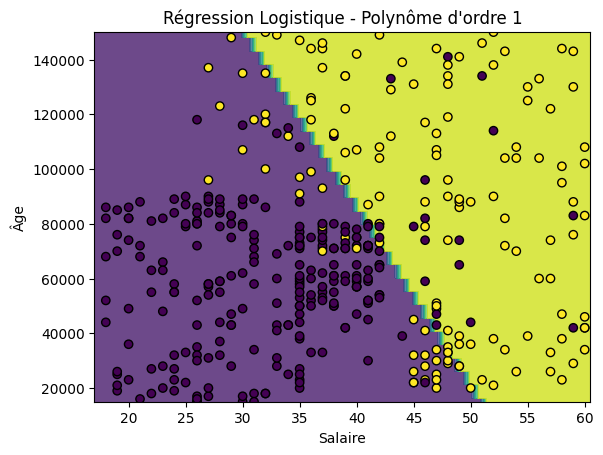

c:\Users\Ahmed_El_Ayeb\Desktop\Ahmed_El_Ayeb\my_project\machine_learining\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


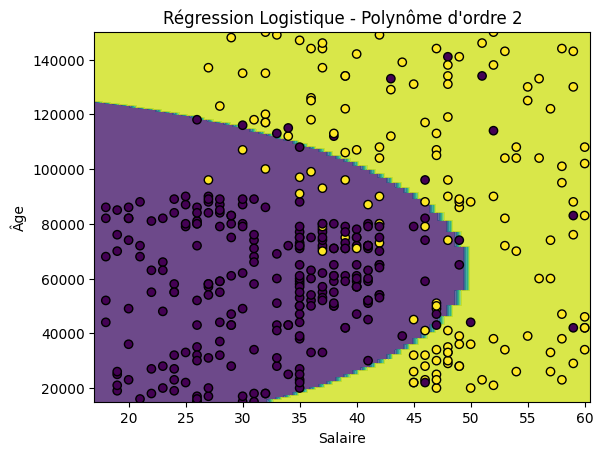

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
y=yt
def logistic_regression_polynomial(X, y, degree=1):
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)
    
    model = LogisticRegression(penalty=None)
    model.fit(X_poly, y)
    
    return model, poly

def plot_decision_boundary(X, y, model, poly, title="Boundary"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.75),
                         np.arange(y_min, y_max, 0.75))
    
    Z = model.predict(poly.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlabel('Salaire')
    plt.ylabel('Âge')
    plt.show()

# Tester pour plusieurs valeurs de n (degré du polynôme)
for n in [1,2]:  
    model, poly = logistic_regression_polynomial(X, y, degree=n)
    
    # Afficher la frontière de décision
    plot_decision_boundary(X, y, model, poly, title=f"Régression Logistique - Polynôme d'ordre {n}")
